In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-fine-food-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240519%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240519T120501Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00d0b4c6e8729e370825b11f3fb5d8a6ec039ae17e292e6f8b41330feaafdbaa4824e329663d9cf6a31481fc59fde6bd51c811b593f175c0b7878b27a8fb62a5beafc80f3909262c3611c6b69463ef5a3bcf98326851773fe506eb5478b3e569772ae14a378af6848d9491469529f6bbd017ac79c102397b858c3b56f34fef441c93a21154a275b68f97d45b63da2cd3e18c2310b9860498f71eda4274899ab312fbb96c11571b018768ea31f71a1af082acc5d526133ad69375e5e4ab3eecd1e4cc1e4bc382d6b1e9739a812dbcceae2aa310dbc1af0a051987c585871a978b471d906db68bbb3d268df1601a1f326913c82a6418a874540d9bd84bf76414e2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 253873708 bytes downloaded
Downloaded and uncompressed: amazon-fine-food-reviews
Data source import complete.


In [2]:
from attention import AttentionLayer

#Import the Libraries

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv",nrows=100000)

# Drop Duplicates and NA values

In [5]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88419 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88419 non-null  int64 
 1   ProductId               88419 non-null  object
 2   UserId                  88419 non-null  object
 3   ProfileName             88419 non-null  object
 4   HelpfulnessNumerator    88419 non-null  int64 
 5   HelpfulnessDenominator  88419 non-null  int64 
 6   Score                   88419 non-null  int64 
 7   Time                    88419 non-null  int64 
 8   Summary                 88419 non-null  object
 9   Text                    88419 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [11]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first five preprocessed reviews

In [12]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [13]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [14]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

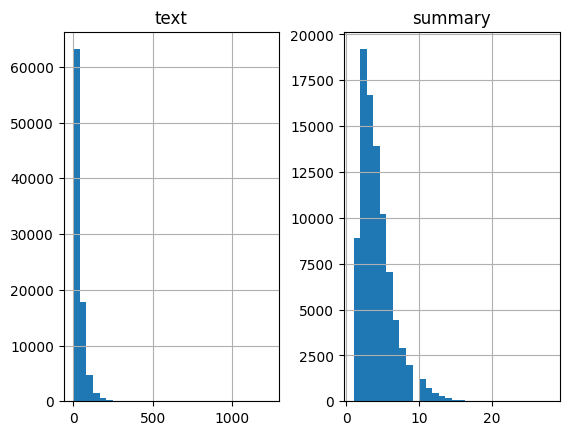

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [18]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424894452681977


In [19]:
max_text_len=30
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [20]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [21]:
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands
...,...,...
47163,stuff awesome best flavor boil water drain water add spice packet add hot water,great stuff
47164,love noodle little spicy wife perfct,good stuff
47165,love buy another box done last one,yummy
47166,favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,great ramen


In [22]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [23]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [27]:
x_tokenizer.word_index

{'great': 1,
 'good': 2,
 'like': 3,
 'love': 4,
 'taste': 5,
 'product': 6,
 'coffee': 7,
 'flavor': 8,
 'one': 9,
 'tea': 10,
 'would': 11,
 'best': 12,
 'price': 13,
 'really': 14,
 'buy': 15,
 'get': 16,
 'amazon': 17,
 'much': 18,
 'find': 19,
 'time': 20,
 'use': 21,
 'little': 22,
 'tried': 23,
 'better': 24,
 'food': 25,
 'well': 26,
 'eat': 27,
 'delicious': 28,
 'make': 29,
 'dog': 30,
 'loves': 31,
 'chocolate': 32,
 'also': 33,
 'bought': 34,
 'order': 35,
 'try': 36,
 'favorite': 37,
 'recommend': 38,
 'even': 39,
 'tastes': 40,
 'found': 41,
 'cup': 42,
 'sweet': 43,
 'cannot': 44,
 'nice': 45,
 'used': 46,
 'store': 47,
 'could': 48,
 'free': 49,
 'drink': 50,
 'bag': 51,
 'perfect': 52,
 'sugar': 53,
 'easy': 54,
 'dogs': 55,
 'way': 56,
 'snack': 57,
 'go': 58,
 'made': 59,
 'ever': 60,
 'ordered': 61,
 'got': 62,
 'box': 63,
 'first': 64,
 'day': 65,
 'tasty': 66,
 'flavors': 67,
 'hot': 68,
 'makes': 69,
 'every': 70,
 'treats': 71,
 'quality': 72,
 'excellent': 73,


In [28]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.07775273663876
Total Coverage of rare words: 2.94478384433473


**Remember**:


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with top most common words for reviews.

In [29]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [30]:
x_voc

8430

In [32]:
x_tr[0]

array([ 259,   46, 1275,  641,  494,  231,  103,  131,   20,  385,   23,
        406,    3,  333,  108,  695,  138,  343,  428,  206,  191,  474,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

#Summary Tokenizer

In [33]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [34]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.2646994054173
Total Coverage of rare words: 5.413717749260335


In [35]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let us check whether word count of start token is equal to length of the training data

In [36]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(42451, 42451)

In [37]:
y_tr[0]

array([ 1,  7, 19,  4,  2,  0,  0,  0], dtype=int32)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [38]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [39]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building



In [40]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              843000    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [44]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
323/323 [==============================] - 153s 418ms/step - loss: 3.0235 - val_loss: 2.7145
Epoch 2/50
323/323 [==============================] - 118s 364ms/step - loss: 2.6975 - val_loss: 2.6103
Epoch 3/50
323/323 [==============================] - 116s 359ms/step - loss: 2.5957 - val_loss: 2.5160
Epoch 4/50
323/323 [==============================] - 117s 361ms/step - loss: 2.5063 - val_loss: 2.4576
Epoch 5/50
323/323 [==============================] - 113s 350ms/step - loss: 2.4467 - val_loss: 2.4042
Epoch 6/50
323/323 [==============================] - 115s 355ms/step - loss: 2.3931 - val_loss: 2.3586
Epoch 7/50
323/323 [==============================] - 112s 346ms/step - loss: 2.3460 - val_loss: 2.3207
Epoch 8/50
323/323 [==============================] - 113s 350ms/step - loss: 2.2988 - val_loss: 2.2802
Epoch 9/50
323/323 [==============================] - 115s 355ms/step - loss: 2.2540 - val_loss: 2.2525
Epoch 10/50
323/323 [==============================] - 115s 357m

In [45]:
# Save the model
model.save('encoder_decoder_model.h5')

#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

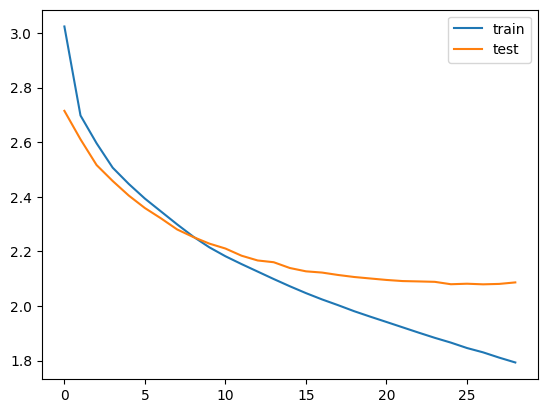

In [47]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [48]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [49]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [51]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [52]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: daughter used quaker instant oatmeal liked lot long time ago tried version like fact want finish sure maybe lots new ingredients artificial 
Original summary: not very good 
1/1 [==============================] - 0s 21ms/step
Predicted summary:  good stuff


Review: liked coffee much subscribing dark rich smooth 
Original summary: makes great cup of java 
1/1 [==============================] - 0s 21ms/step
Predicted summary:  great coffee


Review: like fool ordered box instead bag try disgusting smell like dead fish rinsed rinsed still smelled right light even look purple crack cannot believe stupid buy 
Original summary: gross 
1/1 [==============================] - 0s 24ms/step
Predicted summary:  yuck


Review: flavorful packaged soup long time nice spicy taste good blend herbs cannot wait becomes available stores 
Original summary: delicious treat 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  great


Review: taste like pop refreshing mouth liked 

This is really cool stuff. Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

This is how we can perform text summarization using deep learning concepts in Python.

#How can we Improve the Model’s Performance Even Further?

Your learning doesn’t stop here! There’s a lot more you can do to play around and experiment with the model:

I recommend you to **increase the training dataset** size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size

Try implementing **Bi-Directional LSTM** which is capable of capturing the context from both the directions and results in a better context vector

Use the **beam search strategy** for decoding the test sequence instead of using the greedy approach (argmax)

Evaluate the performance of your model based on the **BLEU score**

Implement **pointer-generator networks** and **coverage mechanisms**




#End Notes

If you have any feedback on this article or any doubts/queries, kindly share them in the comments section over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) and I will get back to you. And make sure you experiment with the model we built here and share your results with me!